<a href="https://colab.research.google.com/github/ArielRoss1605/Simulacion-II/blob/main/MC_Acciones_GOOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import pylab 
from scipy.stats import kstest

In [25]:
RISKY_ASSET = 'GOOG' #empresa google
START_DATE = '2021-01-01'
END_DATE = '2022-06-16'

In [26]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.') #creamos el dataframe 

[*********************100%***********************]  1 of 1 completed
Descargados 366 renglones de datos.


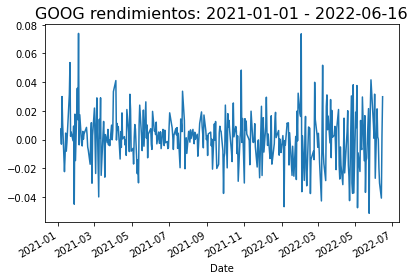

Rendimiento promedio: 0.08%


In [27]:
adj_close = df['Adj Close']  #tomamos los precios ajustados al cierre
returns = adj_close.pct_change().dropna()    #quitamos los datos nulos de nuestra base

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', fontsize=16)
plt.tight_layout()
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')  #Notamos que GOOGLE es una empresa fuerte porque al final de pandemia se 
                                                            #considera que tiene un rendimiento promedio positivo.

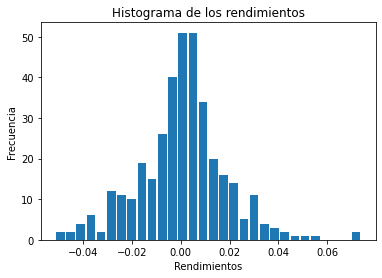

In [28]:
#Buscar verificar si sigue una distribucion normal.
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()
#Por el resultado pareciera que los rendimientos de Google sigue una normal.

In [29]:
#PRIMERA PRUEBA
train = returns['2021-01-01':'2022-03-31'] # tomamos un conjunto de entrenamiento
test = returns['2022-04-01':'2022-06-16']  #tomamos un conjunto de prueba

In [30]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()
print(f'mu: {mu},sigma: {sigma}')

#Podemos apreciar que los rendimientos de google no son tan volatililes por lo que podemos decir que es una empresa solida.

mu: 0.0016718310499291582,sigma: 0.016629819890326403


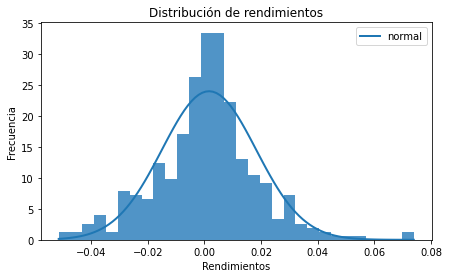

In [31]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();
#Comparacion de histograma y grafica y la mayoría se encuentran por debajo de la curva.Para este punto podriamos decir que si sigue una normal 

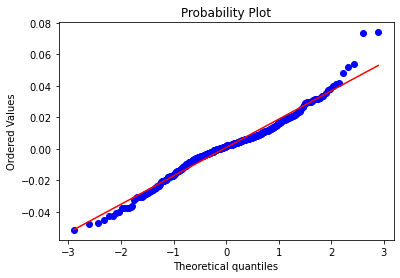

In [32]:
#graficamos por cuantil-cuantil
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

In [33]:
kstest(returns, 'norm', args=(mu, sigma))

#nuestra prueba nos arroja basicamente que sigue una distribucion normal 

KstestResult(statistic=0.06946673157871752, pvalue=0.056271671150564265)

In [38]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):
  np.random.seed(random_seed)  # fijamos la semilla
    
  dt = T/N                     # incremento temporal
  dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
  W = np.cumsum(dW, axis=1)
    
  time_step = np.linspace(dt, T, N)
  time_steps = np.broadcast_to(time_step, (n_sims, N))
    
  S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
  S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
  return S_t

In [40]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
print(gbm_simulations)

[[2792.98999023 2780.69466333 2791.84590538 ... 3481.19009671
  3512.58649075 3583.14767757]
 [2792.98999023 2852.99110625 2880.07619838 ... 2830.3531338
  2751.38927619 2776.21608687]
 [2792.98999023 2895.95049757 2913.41219795 ... 3117.00509934
  3038.99121237 3069.91799538]
 ...
 [2792.98999023 2784.59747865 2719.96334554 ... 3148.27048053
  3192.3431895  3176.29998962]
 [2792.98999023 2824.34230988 2824.37073874 ... 2890.39535899
  2972.52924888 2902.61829495]
 [2792.98999023 2752.7040069  2791.61292224 ... 3019.51449402
  3067.2954676  3082.88246419]]


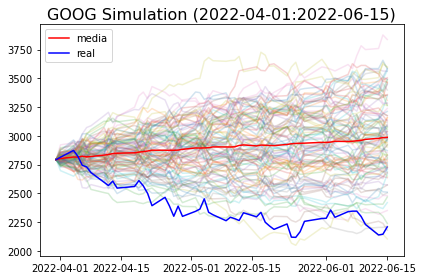

In [41]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

In [46]:
#SEGUNDA PRUEBA
train = returns['2021-01-01':'2021-12-31'] # tomamos un conjunto de entrenamiento
test = returns['2022-01-01':'2022-06-16']  #tomamos un conjunto de prueba

In [47]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()
print(f'mu: {mu},sigma: {sigma}')

#Podemos apreciar que los rendimientos de google no son tan volatililes por lo que podemos decir que es una empresa solida.

mu: 0.0021658764485135403,sigma: 0.01493390290793747


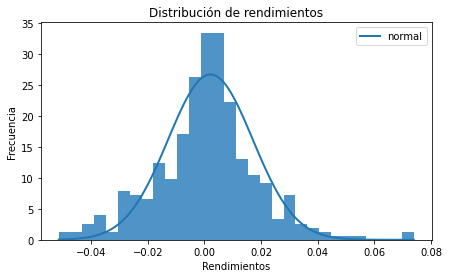

In [48]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

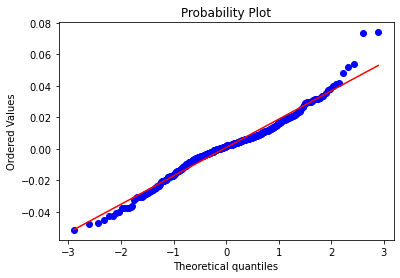

In [49]:
#graficamos por cuantil-cuantil
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

In [50]:
kstest(returns, 'norm', args=(mu, sigma))

#nuestra prueba nos arroja basicamente que sigue una distribucion normal 

KstestResult(statistic=0.06277835102451368, pvalue=0.10790202480081054)

In [51]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
print(gbm_simulations)
#De esta forma, con un p-valor > 0.05, podemos afirmar con un 95% de confianza que nuestros datos se ajustan a una distribución normal.

[[2893.59008789 2884.10083319 2896.44595656 ... 4296.53468744
  4332.80990918 4296.98374592]
 [2893.59008789 2911.16386882 2908.22859948 ... 3098.13130982
  3146.96405417 3112.1210358 ]
 [2893.59008789 2880.23343776 2885.22366428 ... 4151.800632
  4182.79113053 4195.2661811 ]
 ...
 [2893.59008789 2838.26853004 2777.95258075 ... 2936.9210762
  2946.81222782 2924.55544486]
 [2893.59008789 2857.59112899 2884.64136683 ... 3003.04991894
  2869.08123708 2883.61681914]
 [2893.59008789 2837.87197982 2855.05726457 ... 2964.52102983
  2959.62033549 3001.45278587]]


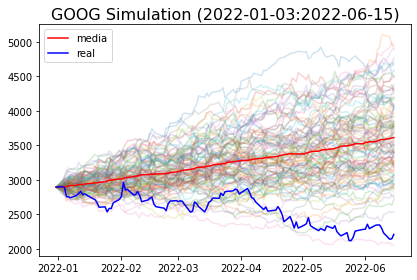

In [52]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

In [53]:
#TERCERA PRUEBA
train = returns['2021-01-01':'2021-06-16'] # tomamos un conjunto de entrenamiento
test = returns['2021-06-17':'2022-06-16']  #tomamos un conjunto de prueba

In [54]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()
print(f'mu: {mu},sigma: {sigma}')

#Podemos apreciar que los rendimientos de google no son tan volatililes por lo que podemos decir que es una empresa solida.

mu: 0.0034673635772783013,sigma: 0.017213844492686585


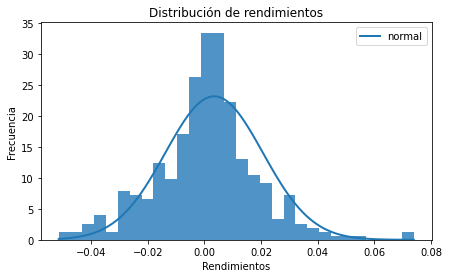

In [55]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

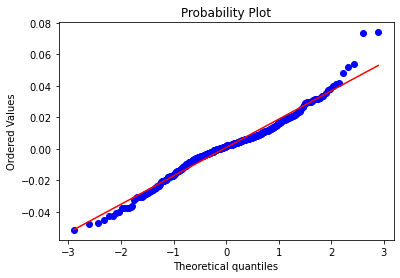

In [56]:
#graficamos por cuantil-cuantil
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

In [57]:
kstest(returns, 'norm', args=(mu, sigma))

#Para este momento al tomar muchos valores podemos decir que aunque pareciera que sigue unda distribucion normal
#Al tomar en cuenta el pvalue nos confirma que los rendimientos no se ajustan a una distribucion normal. 

KstestResult(statistic=0.11362450855176287, pvalue=0.00014642145669044426)

In [58]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
print(gbm_simulations)

[[2513.92993164 2506.81283756 2521.58260917 ... 5354.30007221
  5473.07498159 5382.81765928]
 [2513.92993164 2510.12578314 2491.68288938 ... 6682.62300219
  6785.95082608 6812.53715873]
 [2513.92993164 2463.78994908 2463.82801526 ... 6571.17608235
  6730.39192161 6691.42011272]
 ...
 [2513.92993164 2467.77426571 2476.67290444 ... 5215.90638175
  5028.78070505 5044.0386859 ]
 [2513.92993164 2455.43729479 2362.27092726 ... 6437.90202041
  6394.77707881 6337.60873267]
 [2513.92993164 2449.33056948 2431.5519757  ... 7058.5274116
  6810.13588778 6740.51810052]]


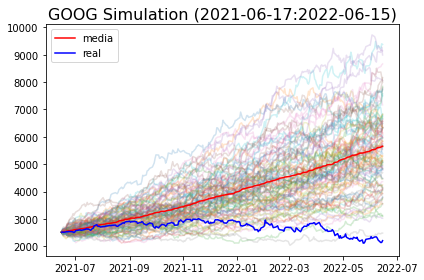

In [59]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()


#Entre más grande sea nuestra muestra en este caso llamada "test" podemos asegurar que no sigue una distribucion normal los rendimientos de GOOG Puesto que varian mucho. 